In [1]:
def ecco_podaac_s3_get(ShortName,StartDate,EndDate,download_root_dir=None,n_workers=6,force_redownload=False):

    
    ## Initalize Python libraries
    import numpy as np
    import pandas as pd
    import requests
    import shutil
    import time as time
    from concurrent.futures import ThreadPoolExecutor
    from platform import system
    from pathlib import Path
    from netrc import netrc
    from os.path import basename, isfile, isdir, join, expanduser
    from urllib import request
    from http.cookiejar import CookieJar
    

    # Predict the path of the netrc file depending on os/platform type.
    _netrc = join(expanduser('~'), "_netrc" if system()=="Windows" else ".netrc")
    

    ## Define Helper Subroutines
    
    ### Helper subroutine to log into NASA EarthData
    
    # not pretty but it works
    def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
        # look for the netrc file and use the login/password
        try:
            username, _, password = netrc(file=_netrc).authenticators(url)
    
        # if the file is not found, prompt the user for the login/password
        except (FileNotFoundError, TypeError):
            print('Please provide Earthdata Login credentials for access.')
            username, password = input('Username: '), getpass('Password: ')
        
        manager = request.HTTPPasswordMgrWithDefaultRealm()
        manager.add_password(None, url, username, password)
        auth = request.HTTPBasicAuthHandler(manager)
        jar = CookieJar()
        processor = request.HTTPCookieProcessor(jar)
        opener = request.build_opener(auth, processor)
        request.install_opener(opener)

    def init_S3FileSystem():
        """
        This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
        through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
        From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
        
        Returns:
        =======
        
        s3: an AWS S3 filesystem
        """
        
        import requests,s3fs
        creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
        s3 = s3fs.S3FileSystem(anon=False,
                               key=creds['accessKeyId'],
                               secret=creds['secretAccessKey'], 
                               token=creds['sessionToken'])
        return s3
    
    ### Helper subroutines to make the API calls to search CMR and parse response
    def set_params(params: dict):
        params.update({'scroll': "true", 'page_size': 2000})
        return {par: val for par, val in params.items() if val is not None}
    
    def get_results(params: dict, headers: dict=None):
        response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.json", 
                                params=set_params(params),
                                headers=headers).json()
        return response    
    
    def get_granules(params: dict):
        response = get_results(params=params)
        if 'feed' in response.keys():
            s3_files_list = []
            for curr_entry in response['feed']['entry']:
                for curr_link in curr_entry['links']:
                    if "direct download access via S3" in curr_link['title']:
                        s3_files_list.append(curr_link['href'])
                        break
        elif 'errors' in response.keys():
            raise Exception(response['errors'][0])

        return s3_files_list


    ### Helper subroutine to gracefully download single files and avoids re-downloading if file already exists.
    # To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)\n,
    def download_file(s3, url, output_dir, force):
        """url (str): the HTTPS url from which the file will download
        output_dir (str): the local path into which the file will download
        force (bool): download even if the file exists locally already
        """
        if not isdir(output_dir):
            raise Exception(f"Output directory doesnt exist! ({output_dir})")
        
        target_file = join(output_dir, basename(url))
        
        # if the file has already been downloaded, skip    
        if isfile(target_file) and force is False:
            print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
            return 0

        # download file to local (output) file directory
        s3.get_file(url, target_file)
    
    
    ### Helper subroutine to download all urls in the list `dls`
    def download_files_concurrently(s3, dls, download_dir, n_workers, force=False):
        start_time = time.time()
    
        # use 3 threads for concurrent downloads
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
    
            # tqdm makes a cool progress bar
            list(tqdm(executor.map(download_file, repeat(s3), dls, repeat(download_dir), repeat(force)),\
                                total=len(dls), desc='DL Progress',\
                                ascii=True, ncols=75, file=sys.stdout))
        
            # calculate total time spent in the download
            total_time_download = time.time() - start_time
    
            print('\n=====================================')
            print('Time spent = ' + str(total_time_download) + ' seconds')        
    

    # set default download parent directory
    if download_root_dir==None:
        download_root_dir = join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC')

    # define the directory where the downloaded files will be saved
    download_dir = Path(download_root_dir) / ShortName
    
    # create the download directory
    download_dir.mkdir(exist_ok = True, parents=True)
    
    print(f'created download directory {download_dir}')
    

    # # Adjust StartDate and EndDate to CMR query values
    
    if StartDate=='yesterday':
        StartDate = yesterday()
    if EndDate==-1:
        EndDate = StartDate
    elif StartDate=='yesterday':
        StartDate = yesterday()
    elif EndDate=='today':
        EndDate = today()
    
    if len(StartDate) == 4:
        StartDate += '-01-01'
    elif len(StartDate) == 7:
        StartDate += '-01'
    elif len(StartDate) != 10:
        sys.exit('\nStart date should be in format ''YYYY'', ''YYYY-MM'', or ''YYYY-MM-DD''!\n'\
                 +'Program will exit now !\n')
    
    if len(EndDate) == 4:
        EndDate += '-12-31'
    elif len(EndDate) == 7:
        EndDate = str(np.datetime64(str(np.datetime64(EndDate,'M')+np.timedelta64(1,'M'))+'-01','D')\
                      -np.timedelta64(1,'D'))
    elif len(EndDate) != 10:
        sys.exit('\nEnd date should be in format ''YYYY'', ''YYYY-MM'', or ''YYYY-MM-DD''!\n'\
                 +'Program will exit now !\n')
    
    
    # for monthly and daily datasets, do not include the month or day before
    if (('MONTHLY' in ShortName) or ('DAILY' in ShortName)):
        if np.datetime64(EndDate,'D') - np.datetime64(StartDate,'D') \
          > np.timedelta64(1,'D'):
            StartDate = str(np.datetime64(StartDate,'D') + np.timedelta64(1,'D'))
            SingleDay_flag = False
        else:
            # for single day ranges we need to make the adjustment
            # after the CMR request
            SingleDay_flag = True
    # for snapshot datasets, move EndDate one day later
    if 'SNAPSHOT' in ShortName:
        EndDate = str(np.datetime64(EndDate,'D') + np.timedelta64(1,'D'))

    
    ## Log into Earthdata using your username and password
    
    # actually log in with this command:
    setup_earthdata_login_auth()
    
    # Query the NASA Common Metadata Repository to find the URL of every granule associated with the desired ECCO Dataset and date range of interest.
    
    # create a Python dictionary with our search criteria:  `ShortName` and `temporal`
    input_search_params = {'ShortName': ShortName,
                           'temporal': ",".join([StartDate, EndDate])}
    
    print(input_search_params)
    
    ### Query CMR for the desired ECCO Dataset
    
    # grans means 'granules', PO.DAAC's term for individual files in a dataset
    s3_files_list = get_granules(input_search_params)
    
    num_grans = len(s3_files_list)
    print (f'\nTotal number of matching granules: {num_grans}')

    # initiate S3 access
    s3 = init_S3FileSystem()
    
    try:
        # Attempt concurrent downloads, but if error arises switch to sequential downloads
        ### Method 1: Concurrent downloads
        
        
        # Force redownload (or not) depending on value of force_redownload
        download_files_concurrently(s3, s3_files_list, download_dir, n_workers, force_redownload)
        
    except:
        ### Method 2: Sequential Downloads
        
        start_time = time.time()
        
        # Download each URL sequentially in a for loop.
        total_download_size_in_bytes = 0
        
        # loop through all files
        for u in s3_files_list:
            u_name = u.split('/')[-1]
            print(f'downloading {u_name}')
            download_file(s3, url=u, output_dir=download_dir, force=force_redownload)
        
        # calculate total time spent in the download
        total_time_download = time.time() - start_time
        
        print('\n=====================================')
        print('Time spent = ' + str(total_time_download) + ' seconds')


In [4]:
%%time
ecco_podaac_s3_get(ShortName="ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                   StartDate="2010-01",EndDate="2010-12",\
                   download_root_dir='/tmp',n_workers=1)

created download directory /tmp/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-01_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-02_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-03_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-04_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-05_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-06_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-07_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-08_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-09_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERA

In [2]:
%%time
ecco_podaac_s3_get(ShortName="ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                   StartDate="2010-01",EndDate="2010-12",\
                   download_root_dir='/tmp',n_workers=2)

created download directory /tmp/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-01_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-02_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-03_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-04_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-05_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-06_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-07_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-08_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-09_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERA

In [5]:
import shutil
shutil.rmtree('/tmp/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4')

In [6]:
%%time
ecco_podaac_s3_get(ShortName="ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                   StartDate="2010-01",EndDate="2010-12",\
                   download_root_dir='/tmp',n_workers=6)

created download directory /tmp/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2010-01-02,2010-12-31'}

Total number of matching granules: 12
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-01_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-02_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-03_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-04_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-05_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-06_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-07_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-08_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERATURE_SALINITY_mon_mean_2010-09_ECCO_V4r4_native_llc0090.nc
downloading OCEAN_TEMPERA

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [9]:
%%time
ds = xr.open_mfdataset("/tmp/ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4/*.nc",\
                       data_vars='minimal',coords='minimal',\
                       compat='override',\
                       chunks={'time':1,'k':50,'tile':13,'j':90,'i':90})

CPU times: user 784 ms, sys: 125 ms, total: 910 ms
Wall time: 927 ms


In [11]:
from ecco_s3_retrieve import *

grid_file = ecco_podaac_s3_retrieve(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                                    StartDate="1992-01",EndDate="2017-12")
ds_grid = xr.open_dataset(grid_file)

{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1992-01-01,2017-12-31'}

Total number of matching granules: 1


In [12]:
from distributed import Client
client = Client("127.0.0.1:43393")
print(client)

<Client: 'tcp://127.0.0.1:43393' processes=2 threads=2, memory=7.50 GiB>


In [13]:
%%time
cell_vol = ds_grid.hFacC*ds_grid.rA*ds_grid.drF
cell_vol = cell_vol.compute()

CPU times: user 147 ms, sys: 33.8 ms, total: 181 ms
Wall time: 183 ms


In [14]:
%%time
total_vol = cell_vol.sum().compute()
theta_global_mean = (cell_vol*ds.THETA).sum(dim=["k","tile","j","i"])/\
                        total_vol

CPU times: user 118 ms, sys: 19.9 ms, total: 138 ms
Wall time: 316 ms


/home/jpluser/miniforge3/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 20.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 54 ms, sys: 17.8 ms, total: 71.8 ms
Wall time: 1.7 s


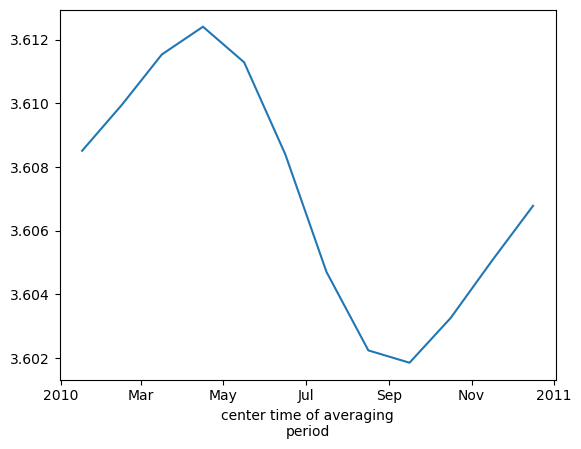

In [15]:
%%time
theta_global_mean = theta_global_mean.compute()
theta_global_mean.plot()